# PET/CT and CT-derived face reconstruction

*MVA Project 2022-2023*

*Authors: Emma Bou Hanna & Sebastian Partarrieu*

In this notebook, we use PET and CT scans to perform facial reconstruction. The main focus here is to explore the use of otsu thresholding to perform better computation of the connected components and mesh rendering.

## Data import

In [17]:
import nibabel as nib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#change paths as needed
pet_img = '../data/PETCT_2d9638360e/09-09-2005-NA-PET-CT Ganzkoerper  primaer mit KM-19870/SUV.nii.gz'
ct_scan = '../data/PETCT_2d9638360e/09-09-2005-NA-PET-CT Ganzkoerper  primaer mit KM-19870/CTres.nii.gz'
original_ct_scan = '../data/PETCT_2d9638360e/09-09-2005-NA-PET-CT Ganzkoerper  primaer mit KM-19870/CT.nii.gz'

In [4]:
img = nib.load(pet_img)
ct = nib.load(ct_scan)
#original_ct = nib.load(original_ct_scan)

In [5]:
#get voxel size
voxel_spacing = img.header.get_zooms()

In [6]:
img_data = img.get_fdata()
ct_data = ct.get_fdata()
#original_ct_data = original_ct.get_fdata()

In [7]:
img_data.shape, ct_data.shape, #original_ct_data.shape

((400, 400, 318), (400, 400, 318))

## Thresholding

Adaptive thresholding on ct data. We want to binarize the ct 3D images to simply segment the outer part of the body as we are interested in facial recognition so we just want to reconstruct the surface from the ct scan. You can see from the histograms of the HU values of the CT scans that otsu finds the correct thresholds fairly easily. This allows better segmentation of the outer part of the body for later visualizations.

### CT scans

In [8]:
from skimage.filters import threshold_otsu, threshold_multiotsu
import seaborn as sns

In [9]:
sns.set_style('dark')

In [11]:
thresh = threshold_otsu(ct_data)

In [12]:
thresholds = threshold_multiotsu(ct_data)

In [13]:
thresholds

array([-515.65574312,  276.35655165])

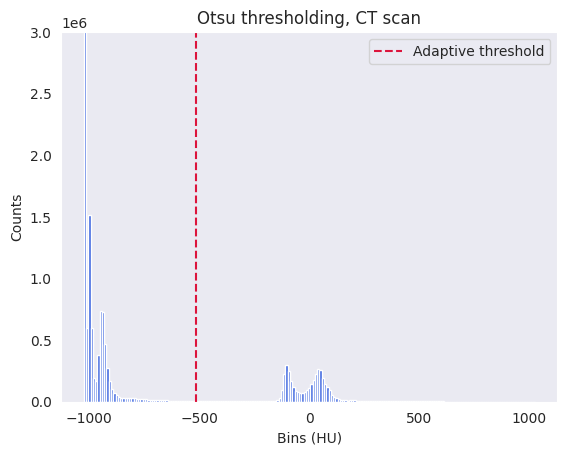

In [14]:
plt.hist(ct_data.flatten(), bins=np.linspace(-1025, 1025, 200), density=False, color='royalblue')
plt.axvline(thresh, linestyle='--', color='crimson', label='Adaptive threshold')
plt.xlabel('Bins (HU)')
plt.ylabel('Counts')
plt.title('Otsu thresholding, CT scan')
plt.legend()
plt.ylim((0., 0.3e7))
#plt.savefig('../figs/otsu_thresholding_downsampled_ct.png')
plt.show()

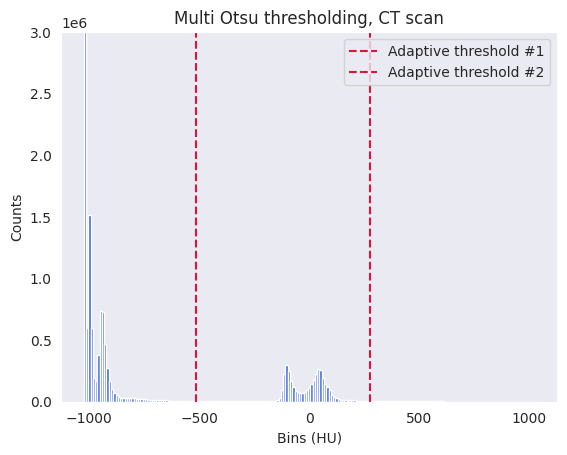

In [15]:
plt.hist(ct_data.flatten(), bins=np.linspace(-1025, 1025, 200), density=False, color='royalblue')
for i, t in enumerate(thresholds):
    plt.axvline(t, linestyle='--', color='crimson', label=f'Adaptive threshold #{i+1}')
plt.xlabel('Bins (HU)')
plt.ylabel('Counts')
plt.title('Multi Otsu thresholding, CT scan')
plt.legend()
plt.ylim((0., 0.3e7))
#plt.savefig('../figs/otsu_thresholding_downsampled_ct.png')
plt.show()

### PET scans

Thresholding on PET scans doesn't work as well automatically as seen below.

In [21]:
thresh_pet = threshold_otsu(img_data)

In [22]:
thresh_pet

6.672750860452652

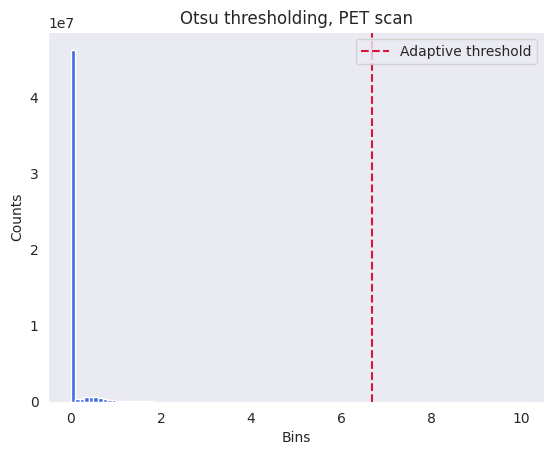

In [23]:
plt.hist(img_data.flatten(), bins=np.linspace(0.0, 10, 100), density=False, color='royalblue')
plt.axvline(thresh_pet, linestyle='--', color='crimson', label='Adaptive threshold')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Otsu thresholding, PET scan')
plt.legend()
#plt.savefig('../figs/otsu_thresholding_one_pet-ct.png')
plt.show()

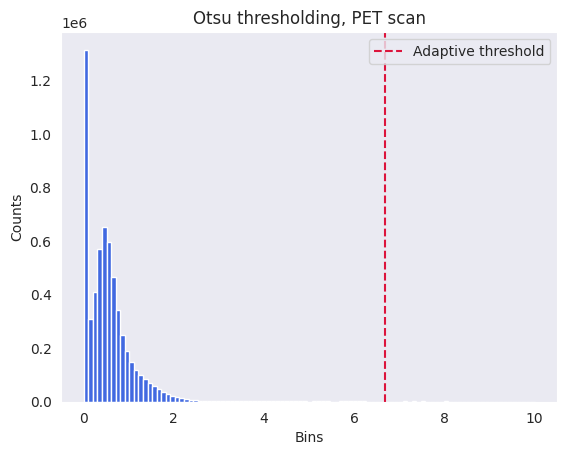

In [24]:
plt.hist(img_data.flatten(), bins=np.linspace(0.01, 10, 100), density=False, color='royalblue')
plt.axvline(thresh_pet, linestyle='--', color='crimson', label='Adaptive threshold')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Otsu thresholding, PET scan')
plt.legend()
#plt.savefig('../figs/otsu_thresholding_one_pet-ct.png')
plt.show()

Instead, we will take a threshold of 0.5 for the PET scans since we don't want to discard too much of the image. This steps isn't the most important as after we will compute the largest connected component and use marching cubes algorithms to do the surface reconstruction.

### Thresholding visualizations


In [25]:
ct_thresholded = (ct_data >= thresholds[0]) & (ct_data <= thresholds[1])
pet_thresholded = img_data > 0.5

In [26]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices), figsize=(12, 8))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, origin="lower")
        axes[i].axis('off')
    plt.show()

#### CT

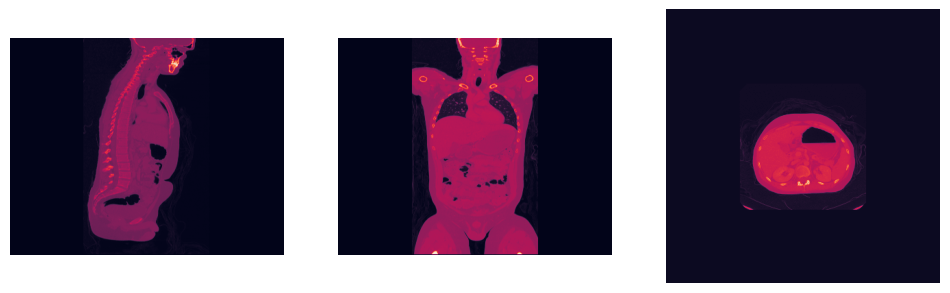

In [27]:
show_slices([ct_data[200, :, :],
             ct_data[:, 200, :],
             ct_data[:, :, 159]])

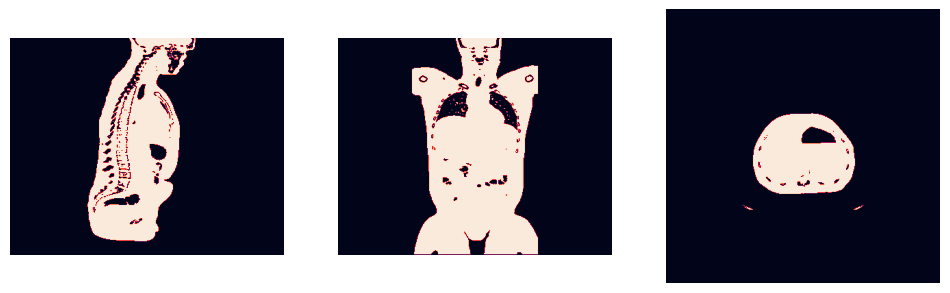

In [28]:
show_slices([ct_thresholded[200, :, :],
             ct_thresholded[:, 200, :],
             ct_thresholded[:, :, 159]])

#### PET

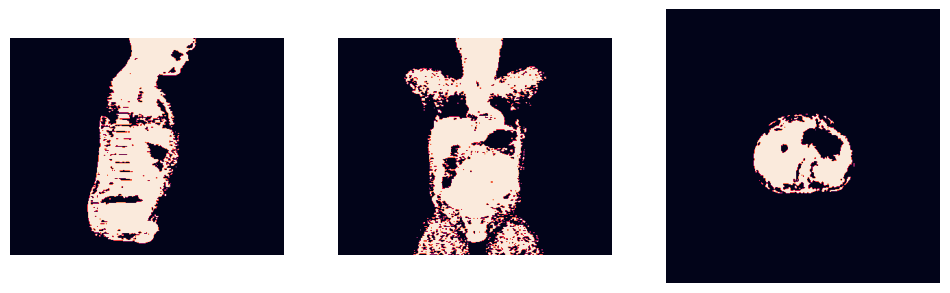

In [29]:
show_slices([pet_thresholded[200, :, :],
             pet_thresholded[:, 200, :],
             pet_thresholded[:, :, 159]])

We already see that the PET data is a lot more sparse than the CT data with many gaps in the surface.

## Getting surfaces

Here, we compute the connected components from the voxel representations, extract the largest component and then apply a marching cubes algorithm to get a mesh representation. Once we have the mesh, we perform ray casting to obtain the surface visualization, which allows us to accurately visualize the face of the person. First, we do this using the CT data, and then we do it with the PET.

**Note: You can easily visualize the surface of a CT or PET in dedicated software. The advantage of what is done here is that by doing it algorithmically, we can do it on hundreds of scans and extract the corresponding faces. This allows us to train specific facial recognition networks for de-anonymizing the scans.**

### CT

In [30]:
import cc3d
labels = cc3d.connected_components(ct_thresholded)
#labels = cc3d.connected_components(pet_thresholded)

In [31]:
morpho = labels.copy()
unique_lab, counts = np.unique(labels, return_counts=True)
skin = unique_lab[np.argsort(counts)[-2]] # first largest comp is background
morpho = (morpho == skin).astype(float)

In [32]:
from skimage import measure
verts, faces, normals, vals = measure.marching_cubes(morpho, .5, spacing=voxel_spacing)

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

In [33]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [34]:
img_dim = (morpho.shape[1], morpho.shape[2])

In [35]:
#initialize mesh
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)

In [36]:
mesh.compute_vertex_normals()

TriangleMesh with 730335 points and 1486700 triangles.

In [37]:
mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=5)

In [38]:
mesh_out.compute_vertex_normals()

TriangleMesh with 730335 points and 1486700 triangles.

In [39]:
#ray casting
mesh_f = o3d.t.geometry.TriangleMesh.from_legacy(mesh_out.translate([0, 0, 0]))

scene = o3d.t.geometry.RaycastingScene()
person_id = scene.add_triangles(mesh_f)

In [41]:
rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=90,
    center=[200*voxel_spacing[0], 0, 230*voxel_spacing[-1]],
    eye=[200*voxel_spacing[0], 400*voxel_spacing[1], 235*voxel_spacing[2]],
    up=[0, 1, 0],
    width_px=1200,
    height_px=1200,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)

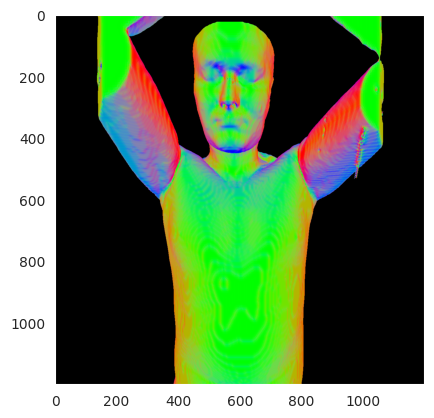

In [42]:
plt.imshow(np.abs(ans['primitive_normals'].numpy()))

### PET

In [43]:
labels = cc3d.connected_components(pet_thresholded)

In [44]:
morpho = labels.copy()
unique_lab, counts = np.unique(labels, return_counts=True)
skin = unique_lab[np.argsort(counts)[-2]] # first largest comp is background
morpho = (morpho == skin).astype(float)

In [45]:
verts, faces, normals, vals = measure.marching_cubes(morpho, .5, spacing=voxel_spacing)

In [46]:
img_dim = (morpho.shape[1], morpho.shape[2])

In [47]:
#initialize mesh
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)

In [48]:
mesh.compute_vertex_normals()

TriangleMesh with 1448104 points and 2935792 triangles.

In [49]:
mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=5)

In [50]:
mesh_out.compute_vertex_normals()

TriangleMesh with 1448104 points and 2935792 triangles.

In [51]:
#ray casting
mesh_f = o3d.t.geometry.TriangleMesh.from_legacy(mesh_out.translate([0, 0, 0]))

scene = o3d.t.geometry.RaycastingScene()
person_id = scene.add_triangles(mesh_f)

In [52]:
rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=90,
    center=[200*voxel_spacing[0], 0, 230*voxel_spacing[-1]],
    eye=[200*voxel_spacing[0], 400*voxel_spacing[1], 235*voxel_spacing[2]],
    up=[0, 1, 0],
    width_px=1200,
    height_px=1200,
)
# We can directly pass the rays tensor to the cast_rays function.
ans = scene.cast_rays(rays)

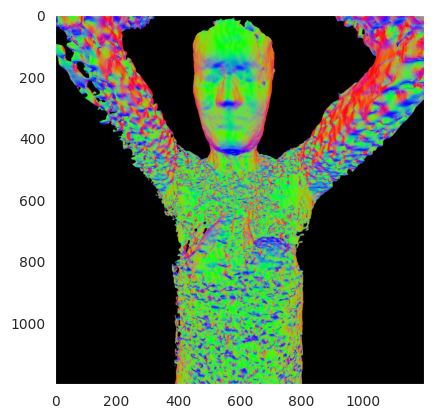

In [53]:
plt.imshow(np.abs(ans['primitive_normals'].numpy()))

**End of notebook**

## 